# Deface Detector - V2

In [2]:
import cv2
import numpy as np
import os
import nibabel as nib
import matplotlib.pyplot as plt
import random
import time

In [3]:
class FileLoader:
    '''Extracts necessary files to generate dataset,
    and handles splitting the files for training and testing'''
    
    def __init__(self, path):
        self.path = path
        self.image_files = list()
        self._load_files(self.path)
        
    def _load_files(self, path):
        '''Recursively goes into the path to extract all NIFTI image filenames (relative to path). 
        Defaced and Undefaced MRI images are treated alike.'''
    
        if path.endswith('nii.gz'):
            self.image_files.append(path)
        elif os.path.isdir(path):
            for file in os.listdir(path):
                self._load_files(os.path.join(path,file))
            
    def train_test_split(self, split=0.8, shuffle=True):
        '''Shuffles, splits and returns train and test set as filenames'''
        
        if shuffle:
            random.shuffle(self.image_files)
            
        split_index = int(split*len(self.image_files))
        train_files = self.image_files[:split_index]
        test_files = self.image_files[split_index:]
        
        return train_files, test_files
        

In [8]:
# Recursively extracts relevant filenames from the path specified

path = '../mri_data/small_set'

file_loader = FileLoader(path)

print('Total Number of Images :', len(file_loader.image_files))

Total Number of Images : 38


In [9]:
# Shuffles and splits the image files into train and validation set

train_files, test_files = file_loader.train_test_split(split=0.8, shuffle=True)

print('Number of train images :', len(train_files))
print('Number of test images :', len(test_files))

Number of train images : 30
Number of test images : 8


In [10]:
class Cache:
    '''A cache to store the train and validation datasets which are transformed to a trainable format'''
    
    def __init__(self, files, batch_size, verbose=0):
        self.files = files
        self.batch_size = batch_size
        self.verbose = verbose
        self.dim_0 = np.empty(len(train_files), dtype=object)
        self.dim_1 = np.empty(len(train_files), dtype=object)
        self.dim_2 = np.empty(len(train_files), dtype=object)
        self.y = list()
        self._read_images()
        
    def read_mri_image(self, filename):
        '''Utility function to read a single MRI image,
        as a numpy array'''
    
        img = nib.load(filename)
        return img.get_data()
        
    def _batch_read(self, files, start_index):
        '''Reads MRI images batch by batch. All defaced images are identified by a "deface" in the file name. 
        This function was needed due to certain unknown errors in the GPU cluster'''
        
        i = start_index
        
        for f in files:            
            img = self.read_mri_image(f)
            
            m0 = np.mean(img,axis=0)
            m1 = np.mean(img,axis=1)
            m2 = np.mean(img,axis=2)
            
            self.dim_0[i] = m0
            self.dim_1[i] = m1
            self.dim_2[i] = m2
            
            i+=1
            
            if 'deface' in f:
                self.y.append(1)
            else:
                self.y.append(0) 
    
    def _read_images(self):
        start = time.time()
        
        for i in range(0,len(self.files),self.batch_size):
            if i+self.batch_size > len(self.files):
                self._batch_read(self.files[i:], i)
                if self.verbose==1:
                    print(len(self.files), " Done")
            else:
                self._batch_read(self.files[i:i+self.batch_size], i)
                if self.verbose==1:
                    print(i+self.batch_size, " Done")
                    
        if self.verbose==1:
            print("Time Taken : ", time.time()-start)
        

In [12]:
# Acts as a cache for dataset
print('Loading Training Cache..')
train_cache = Cache(train_files, 20, verbose=1)
print('Loading Testing Cache..')
test_cache = Cache(test_files, 20, verbose=1)

Loading Training Cache..
20  Done
30  Done
Time Taken :  5.544640064239502
Loading Testing Cache..
8  Done
Time Taken :  1.7390458583831787


In [15]:
import imgaug as ia
from imgaug import augmenters as iaa
from keras import layers, models

Using TensorFlow backend.


In [22]:
def _Conv_BN_RELU(x, filters=32, kernel=3, strides=1, padding='same'):
    '''Helper to create a modular unit containing Convolution, BatchNormalizaton and Activation'''

    x = layers.Conv2D(filters,kernel,strides=strides,padding=padding)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x  

def create_submodel():
    '''The feature extracting submodel for which shares parameters'''

    inp = layers.Input(shape=(None,None,1))

    conv1 = _Conv_BN_RELU(inp, filters=8, kernel=5, strides=4, padding='same')

    conv2 = _Conv_BN_RELU(conv1, filters=16, kernel=5, strides=1, padding='same')
    conv2 = _Conv_BN_RELU(conv2, filters=16, kernel=2, strides=2, padding='same')

    conv3 = _Conv_BN_RELU(conv2, filters=24, kernel=5, strides=1, padding='same')
    conv3 = _Conv_BN_RELU(conv3, filters=24, kernel=2, strides=2, padding='same')

    conv4 = _Conv_BN_RELU(conv2, filters=32, kernel=5, strides=1, padding='same')
    conv4 = _Conv_BN_RELU(conv3, filters=32, kernel=2, strides=2, padding='same')

    out = layers.GlobalAveragePooling2D()(conv4)

    submodel = models.Model(inp,out)
    
    return submodel


def create_model():
    '''Assembles all the submodels into a unified single model'''

    inp1 = layers.Input(shape=(None,None,1), name='input_1')
    inp2 = layers.Input(shape=(None,None,1), name='input_2')
    inp3 = layers.Input(shape=(None,None,1), name='input_3')

    submodel = create_submodel()

    one = submodel(inp1)
    two = submodel(inp2)
    three = submodel(inp3)

    concat = layers.Concatenate()([one,two,three])
    dropout = layers.Dropout(0.5)(concat)
    out = layers.Dense(1,activation='sigmoid',name='output_node')(dropout)

    model = models.Model(inputs=[inp1,inp2,inp3],outputs=out)

    return model


In [23]:
# Create and compile Keras model
model = create_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32)           20000       input_1[0][0]                    
                                                                 input_2[0][0]                    
          

In [28]:
def augment(images, target_size=None):
    '''Function for augmenting MRI images while training, to increase generalization'''

    sometimes = lambda aug : iaa.Sometimes(0.2,aug)

    # The commented augmentations sometimes destroyed the image. Need to discuss which ones are appropriate here

    seq = iaa.Sequential([
        sometimes(iaa.GaussianBlur(sigma=(0.0,2.0))),
#         sometimes(iaa.ContrastNormalization((0.9,1.1))),
#         sometimes(iaa.Multiply((0.95,1.05))),
#         iaa.Sharpen(alpha=(0, 0.5), lightness=(0.9, 1.1)),
        iaa.Fliplr(0.5),
        iaa.Flipud(0.5),

        iaa.OneOf([
            iaa.Affine(rotate=(90)),
            iaa.Affine(rotate=(-90)),
            iaa.Affine(rotate=(0))
        ])
    ])

    float_images = []

    if target_size:
        for j in range(len(images)):
            img = images[j]
            float_images.append(cv2.resize(img.astype('float'), target_size))

    seq_det = seq.to_deterministic()
    aug_images = seq_det.augment_images(float_images)

    aug_images = np.expand_dims(aug_images, axis=3)

    return aug_images


def generator(batch_size, train=True):
    '''Generator for feeding the model while training'''

    # The images are resized to one of the following images. As the network is an FCN, this is ace
    sizes = [(64,64),(128,128),(192,192),(256,256)]

    while True:

        if train:
            for i in range(0, len(train_files), batch_size):

                batch_x_0 = augment(train_cache.dim_0[i:i+batch_size], target_size=random.choice(sizes))
                batch_x_1 = augment(train_cache.dim_1[i:i+batch_size], target_size=random.choice(sizes))
                batch_x_2 = augment(train_cache.dim_2[i:i+batch_size], target_size=random.choice(sizes))

                batch_y = train_cache.y[i:i+batch_size]

                yield ([batch_x_0, batch_x_1, batch_x_2], np.array(batch_y))

        else:
            for i in range(0, len(test_files), batch_size):

                batch_x_0 = np.expand_dims([test_cache.dim_0[i].astype('float')], axis=3)
                batch_x_1 = np.expand_dims([test_cache.dim_1[i].astype('float')], axis=3)
                batch_x_2 = np.expand_dims([test_cache.dim_2[i].astype('float')], axis=3)

                batch_y = test_cache.y[i:i+batch_size]

                yield ([batch_x_0, batch_x_1, batch_x_2], np.array(batch_y))

(64, 64, 1)


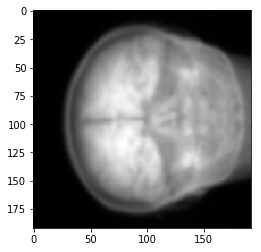

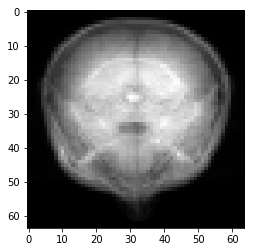

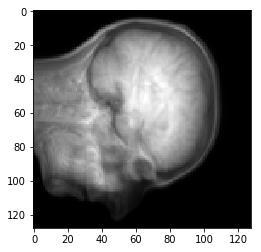

In [29]:
# Test to check generator

g = generator(4)
batch_x, batch_y = next(g)
print(batch_x[1][2].shape)

plt.imshow(np.squeeze(batch_x[0][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[1][0]), 'gray')
plt.show()

plt.imshow(np.squeeze(batch_x[2][0]), 'gray')
plt.show()

In [30]:
# Create necessary folders for logging and saving
os.makedirs('models',exist_ok=True)
os.makedirs('logs',exist_ok=True)

In [31]:
from keras.callbacks import ModelCheckpoint, CSVLogger

batch_size = 4

train_gen = generator(batch_size, train=True)
val_gen = generator(1, train=False)

checkpoint = ModelCheckpoint(filepath='models/model_best.h5', save_best_only=True, monitor='val_loss',
                             save_weights_only=False)

csv_logger = CSVLogger('logs/training.log')

# Training with checkpoints for saving and logging results
model.fit_generator(train_gen, steps_per_epoch=len(train_files)//batch_size,
                    validation_data=val_gen, validation_steps=len(test_files),
                    epochs=1, callbacks=[checkpoint, csv_logger])

# NOTE: The results below are just for a sample dataset

Epoch 1/1
7/7 [==============================] - 1s 196ms/step - loss: 0.7634 - acc: 0.5000 - val_loss: 0.6689 - val_acc: 0.3750


In [ ]:
# Save and load model
model.save('models/model_final.h5')

from keras.models import load_model
model = load_model('models/model_best.h5')